# AngularSeparation
The `freud.environment` module analyzes the local environments of particles. The `freud.environment.AngularSeparation` class enables direct measurement of the relative orientations of particles.

In [1]:
import freud
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.titlepad'] = 20 
from mpl_toolkits.mplot3d import Axes3D
import rowan  # for quaternion math, see rowan.readthedocs.io for more information.

In order to work with orientations in freud, we need to do some math with quaternions.
If you are unfamiliar with quaternions, you can read more about [their definition](https://en.wikipedia.org/wiki/Quaternion) and how they can be used to [represent rotations](https://en.wikipedia.org/wiki/Quaternions_and_spatial_rotation).
For the purpose of this tutorial, just consider them as 4D vectors, and know that the set of normalized (*i.e.* unit norm) 4D vectors can be used to represent rotations in 3D.
In fact, there is a 1-1 mapping between normalized quaternions and 3x3 rotation matrices.
Quaternions are more computationally convenient, however, because they only require storing 4 numbers rather than 9, and they can be much more easily chained together.
The rowan library ([rowan.readthedocs.io](https://rowan.readthedocs.io/)) defines many useful operations using quaternions, such as the rotations of vectors using quaternions instead of matrices.

## Neighbor Angles

One usage of the AngularSeparation class is to compute angles between neighboring particles.
To show how this works, we generate a simple configuration of particles with random orientations associated with each point.

In [2]:
uc = freud.data.UnitCell.sc()
box, positions = uc.generate_system(5)
N = len(positions)

# Generate random, correlated particle orientations by taking identity
# quaternions and slightly rotating them in a random direction
np.random.seed(0)
interpolate_amount = 0.2
identity_quats = np.array([[1, 0, 0, 0]] * N)
ref_orientations = rowan.interpolate.slerp(
    identity_quats, rowan.random.rand(N), interpolate_amount)
orientations = rowan.interpolate.slerp(
    identity_quats, rowan.random.rand(N), interpolate_amount)

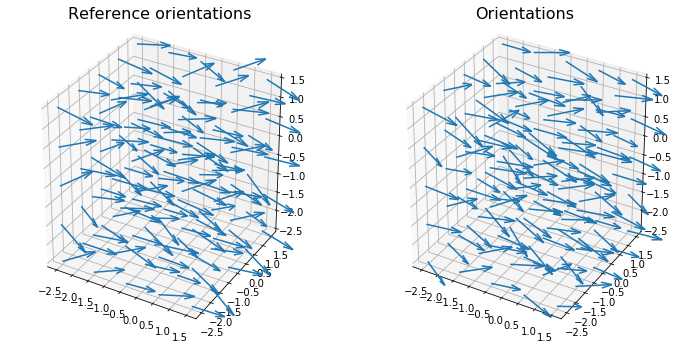

In [3]:
# To show orientations, we use arrows rotated by the quaternions.
ref_arrowheads = rowan.rotate(ref_orientations, np.array([1, 0, 0]))
arrowheads = rowan.rotate(orientations, np.array([1, 0, 0]))

fig = plt.figure(figsize=(12, 6))
ref_ax = fig.add_subplot(121, projection='3d')
ax = fig.add_subplot(122, projection='3d')
ref_ax.quiver3D(positions[:, 0], positions[:, 1], positions[:, 2],
                ref_arrowheads[:, 0], ref_arrowheads[:, 1], ref_arrowheads[:, 2])
ax.quiver3D(positions[:, 0], positions[:, 1], positions[:, 2],
            arrowheads[:, 0], arrowheads[:, 1], arrowheads[:, 2])
ref_ax.set_title("Reference orientations", fontsize=16)
ax.set_title("Orientations", fontsize=16)
plt.show()

We can now use the AngularSeparation class to compare the orientations in these two systems.

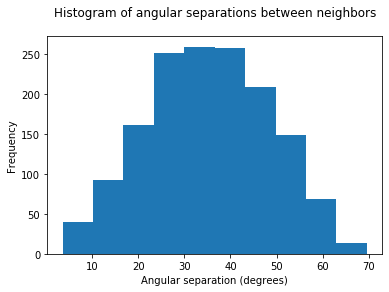

In [4]:
# For simplicity, we'll assume that our "particles" are completely
# asymmetric, i.e. there are no rotations that map the particle
# back onto itself. If we had a regular polyhedron, then we would
# want to specify all the quaternions that rotate that polyhedron
# onto itself.
equiv_orientations = np.array([[1, 0, 0, 0]])
ang_sep = freud.environment.AngularSeparationNeighbor()
ang_sep.compute((box, positions), orientations,
                positions, ref_orientations,
                equiv_orientations, neighbors={'num_neighbors': 12})

# Convert angles from radians to degrees and plot histogram
neighbor_angles = np.rad2deg(ang_sep.angles)
plt.hist(neighbor_angles)
plt.title('Histogram of angular separations between neighbors')
plt.xlabel('Angular separation (degrees)')
plt.ylabel('Frequency')
plt.show()

## Global Angles

Alternatively, the AngularSeparationGlobal class can also be used to compute the orientation of all points in the system relative to some global set of orientations.
In this case, we simply provide a set of global quaternions that we want to consider.
For simplicity, let's consider $180^\circ$ rotations about each of the coordinate axes, which have very simple quaternion representations.

In [5]:
global_orientations = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
ang_sep = freud.environment.AngularSeparationGlobal()
ang_sep.compute(global_orientations, ref_orientations, equiv_orientations)
global_angles = np.rad2deg(ang_sep.angles)

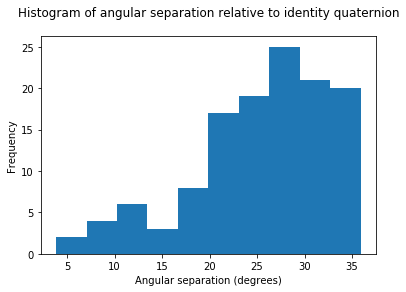

In [6]:
plt.hist(global_angles[:, 0])
plt.title('Histogram of angular separation relative to identity quaternion')
plt.xlabel('Angular separation (degrees)')
plt.ylabel('Frequency')
plt.show()

As a simple check, we can ensure that for the identity quaternion $(1, 0, 0, 0)$, which performs a $0^\circ$ rotation, the angles between the reference orientations and that quaternion are equal to the original angles of rotation of those quaternions (*i.e.* how much those orientations were already rotated relative to the identity).

In [7]:
ref_axes, ref_angles = rowan.to_axis_angle(ref_orientations)
np.allclose(global_angles[:, 0], np.rad2deg(ref_angles), rtol=1e-4)

True